### Main project: Autoencoder with Convolutional Neural Network
This notebook contains the implementation of an autoencoder for augmentation of the histopathology dataset. The augmented data is used to train CNN networks to see if the accuracy and AUC are higher compared to the baseline CNN model trained on the normal dataset. First, the required libraries are imported and the size of the images in the PCAM dataset is defined.

In [1]:
# Load the functions and classes from main_util.py
from main_util import get_pcam_generators
from main_util import Model_architecture
from main_util import Model_transform

# ROC curve analysis
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Standard libraries
import matplotlib.pyplot as plt

### Evaluating baseline CNN model trained on regular data

Firstly, the filepath to the folder containing the `train+val` map of the dataset is defined. This variable should be adjusted based on your file system. Next, the model name and the filepath for the model weights are defined. 

In [2]:
# Defining dataset file path
path = "../data"

# Defining model name and filepath for the weights
model_name = "cnn_baseline"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

The code block directly below can be used to load the CNN baseline model. This already trained model can be trained in the `main_manual_training.ipynb` file.

In [3]:
# Load weights into the model (ONLY IF MODEL ALREADY EXISTS!!!)
model_cnn = Model_architecture()
model_cnn.create_cnn(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64)
model_cnn.compile_cnn(learning_rate=0.001)

model_cnn.load_weights(weights_filepath)

# Variables for ROC analysis
train_gen, val_gen = get_pcam_generators(path, 
                                         train_batch_size=16, 
                                         val_batch_size=16,
                                         class_mode="binary")

train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

# Print statement to check if correct model is loaded
print(f"Successfully loaded the following model: {model_name}")

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Successfully loaded the following model: cnn_baseline


Now, ROC curve analysis is performed on the baseline CNN model using the code below. Note that the AUC is obtained from the validation set and not the testing set (via Kaggle).

1000/1000 [==============================] - 98s 91ms/step


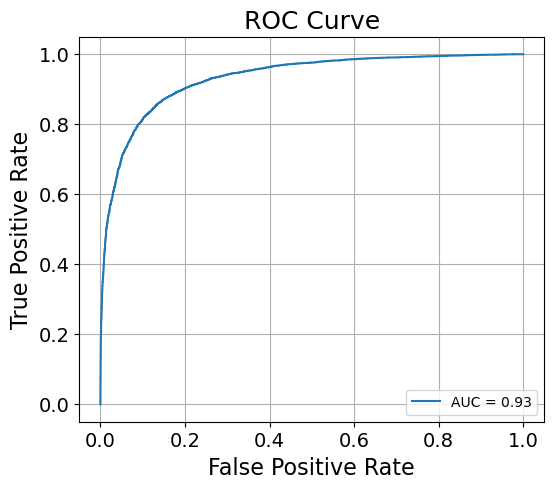

In [4]:
# Getting labels and predictions on validation set
val_true = val_gen.classes
val_probs = model_cnn.predict(val_gen, steps=val_steps)

# Calculating false positive rate (fpr), true positive rate (tpr) and AUC
fpr, tpr, thresholds = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)

# Generate ROC curve
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
fig, ax = plt.subplots(1, 1, figsize=(6,5))

roc.plot(ax=ax);
ax.set_title('ROC Curve', size=18)
ax.set_xlabel('False Positive Rate', size=16)
ax.set_ylabel('True Positive Rate', size=16)
ax.tick_params(axis="both", labelsize=14)
ax.grid()

### Evaluating the autoencoder model

Again, the model name and the filepath to the weights are defined. It is not possible to do ROC-curve analysis on the autoencoder. Therefore, an augmented image is shown in comparison to the original. 

In [5]:
# Defining model name and paths
model_name = "autoencoder"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

The code block directly below can be used to load the autoencoder model. This already trained model is trained in the `main_manual_training.ipynb` file. 

In [6]:
# Load weights into the model (ONLY IF MODEL ALREADY EXISTS!!!)
model_ae = Model_architecture()
model_ae.create_autoencoder(kernel_size=(3,3), pool_size=(2,2), first_filters=32, second_filters=16)
model_ae.compile_autoencoder(learning_rate=0.001)

model_ae.load_weights(weights_filepath)

# Variables for ROC analysis
train_gen_ae, val_gen_ae = get_pcam_generators(path, 
                                               train_batch_size=16, 
                                               val_batch_size=16, 
                                               class_mode="input") 

train_steps = train_gen_ae.n//train_gen_ae.batch_size
val_steps = val_gen_ae.n//val_gen_ae.batch_size

# Print statement to check if correct model is loaded
print(f"Successfully loaded the following model: {model_name}")

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Successfully loaded the following model: autoencoder


The output of the autoencoder model is visualized. This output  is used as augmented dataset in the upcoming steps.

1/1 [==============================] - 1s 645ms/step


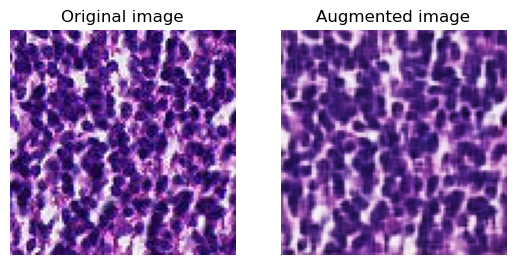

In [7]:
# Produce a prediction on the validation set
img_batch = train_gen_ae[0][1] # [batch][class][image_nr]
predict_test = model_ae.predict(img_batch) 
image_nr = 0

# Plot both patches
fig,ax = plt.subplots(1,2)

ax[0].imshow(img_batch[image_nr])
ax[0].set_title("Original image")
ax[0].axis("off")
ax[1].imshow(predict_test[image_nr])
ax[1].set_title("Augmented image");
ax[1].axis("off");

### Evaluating CNN with augmented data using autoencoder

The model name and filepaths for the saved model are defined.

In [8]:
# Defining model name and filepath to the model weights
model_name = "cnn_augmented"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

The code block directly below can be used to load the CNN with augmented data model. This already trained model is trained in the `main_manual_training.ipynb` file. The variable `AUGMENTATION_FACTOR` can be changed to select between the augmented CNN models.

In [9]:
# Load weights into the model (only if model structure & weight already exist!)
AUGMENTATION_FACTOR = 0.25  # Use 0.25 or 0.50 or 0.75 or 1

weights_filepath_AF = f"trained_models/{model_name}_{str(AUGMENTATION_FACTOR)}_weights.hdf5"

model_cnn_aug = Model_architecture()
model_cnn_aug.create_cnn(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64)
model_cnn_aug.compile_cnn(learning_rate=0.001)

model_cnn_aug.load_weights(weights_filepath_AF)

# Variables for ROC analysis
transformation = Model_transform(ae_model=model_ae, augmentation_factor=AUGMENTATION_FACTOR)
train_gen_aug, val_gen_aug = get_pcam_generators(path, 
                                                 train_batch_size=16,
                                                 val_batch_size=16,
                                                 class_mode="binary", 
                                                 prep_function=transformation.model_transform)

train_steps = train_gen_aug.n//train_gen_aug.batch_size
val_steps = val_gen_aug.n//val_gen_aug.batch_size

# Print statement to check if correct model is loaded
print(f"Successfully loaded the following model: {model_name}_{str(AUGMENTATION_FACTOR)}")

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Successfully loaded the following model: cnn_augmented_0.25


Now, ROC curve analysis is performed on the augmented CNN model using the code below. Note that the AUC is obtained from the validation set and not the testing set (via Kaggle).

1000/1000 [==============================] - 93s 93ms/step


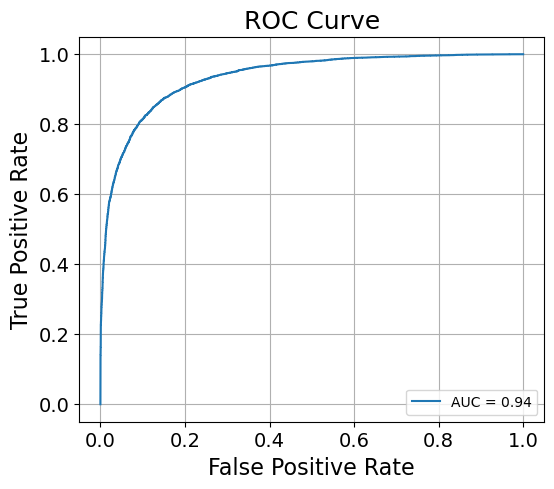

In [10]:
# Getting labels and predictions on validation set
val_true = val_gen_aug.classes
val_probs = model_cnn_aug.predict(val_gen_aug, steps=val_steps)

# Calculating false positive rate (fpr), true positive rate (tpr) and AUC
fpr, tpr, thresholds = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)

# Generate ROC curve
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
fig, ax = plt.subplots(1, 1, figsize=(6,5))

roc.plot(ax=ax);
ax.set_title('ROC Curve', size=18)
ax.set_xlabel('False Positive Rate', size=16)
ax.set_ylabel('True Positive Rate', size=16)
ax.tick_params(axis="both", labelsize=14)
ax.grid()